In [1]:
import torch
#torch.cuda.set_per_process_memory_fraction(0.5, 0)
#torch.cuda.empty_cache()
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 
import math 
from skimage.io import imread, imshow
import os

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Carga de datos

In [3]:
path_data = r'C:\Users\flore\Documents\Utec\ME-2021-2\Teoría y Algoritmos para el Aprendizaje Automático (CS8113)\Proyectos\Proyecto 4\dataset'

In [4]:
path_val_low  = path_data + '\\'+ 'val/low_res'
path_val_high = path_data + '\\'+ 'val/high_res'
path_test_low = path_data + '\\'+ 'train/low_res'
path_test_high= path_data + '\\'+ 'train/high_res'
path_raw_low  = path_data + '\\'+ 'RawData/low_res'
path_raw_high = path_data + '\\'+ 'RawData/high_res'

In [5]:
import os
import cv2

def get_imagenes(dir_path):
  imagenes = []
  for img_path in os.listdir(dir_path):
    img_full_path = os.path.join(dir_path, img_path)
    img = cv2.imread(img_full_path)
    imagenes.append(img)
  return imagenes

In [6]:
path_val  = path_data + '\\' + 'val\\'
path_train = path_data + '\\' +'train\\'
path_raw  = path_data + '\\'+ 'RawData\\'

In [7]:
img_val = torchvision.datasets.ImageFolder(root=path_val, transform = transform.ToTensor())
img_train = torchvision.datasets.ImageFolder(root=path_train, transform = transform.ToTensor())

In [8]:
print(img_val.classes)
print(img_train.classes)
print(len(img_val))
print(len(img_train))

['high_res', 'low_res']
['high_res', 'low_res']
340
1370


In [9]:
import torch.utils.data as data_utils

# indices = torch.arange(0,170)
# img_val_high = data_utils.Subset(img_val, indices)
# indices = torch.arange(170,340)
# img_val_low = data_utils.Subset(img_val, indices)

indices = torch.arange(0,685)
img_train_high = data_utils.Subset(img_train, indices)
indices = torch.arange(685,1370)
img_train_low = data_utils.Subset(img_train, indices)

In [10]:
import random
cantidad = 170
n_test = int(cantidad*0.30)
test_list1 = random.sample(range(cantidad), n_test)
test_list2 = [x + 170 for x in test_list1]

In [11]:
val_list1=[]
for i in range(cantidad):
    if i not in test_list1:
        val_list1.append(i)
random.shuffle(val_list1)
val_list2 = [x + 170 for x in val_list1]

In [12]:
img_val_high = data_utils.Subset(img_val, val_list1)
img_val_low = data_utils.Subset(img_val, val_list2)

img_test_high = data_utils.Subset(img_val, test_list1)
img_test_low = data_utils.Subset(img_val, test_list2)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 8

img_transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5,),(0.5,))]) 

train_set = img_train
test_set = img_val

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

train_loader_lowres = torch.utils.data.DataLoader(dataset=img_train_low, batch_size=batch_size, shuffle=False)
train_loader_highres = torch.utils.data.DataLoader(dataset=img_train_high, batch_size=batch_size, shuffle=False)

val_loader_lowres = torch.utils.data.DataLoader(dataset=img_val_low, batch_size=batch_size, shuffle=False)
val_loader_highres = torch.utils.data.DataLoader(dataset=img_val_high, batch_size=batch_size, shuffle=False)

test_loader_lowres = torch.utils.data.DataLoader(dataset=img_test_low, batch_size=batch_size, shuffle=False)
test_loader_highres = torch.utils.data.DataLoader(dataset=img_test_high, batch_size=batch_size, shuffle=False)

cuda:0


In [14]:
from skimage.io import imread, imshow
def Show_imgs(imgs, name,  size = 4, color = True):
  color_m ='jet'
  if color == False:
    color_m ='gray'
  print('******************' + name  +  '**************************')
  img_numbers = imgs.shape[0]
  rows = cols = math.ceil(np.sqrt(img_numbers))
  
  fig = plt.figure(figsize=(rows*size, cols*size))
  
  for i in range(0, rows*cols):
    fig.add_subplot(rows, cols,i+1)
    if i<img_numbers:
      #plt.imshow(imgs[i].detach(), cmap = 'gray')
      plt.imshow(imgs[i].detach())
      #interpolation=NONE
  plt.show()

## Visualización de imágenes

******************1**************************


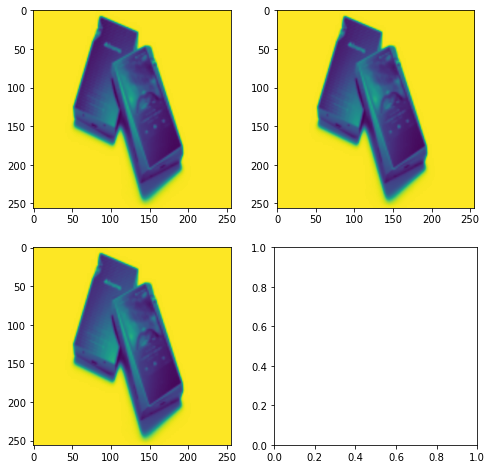

******************0**************************


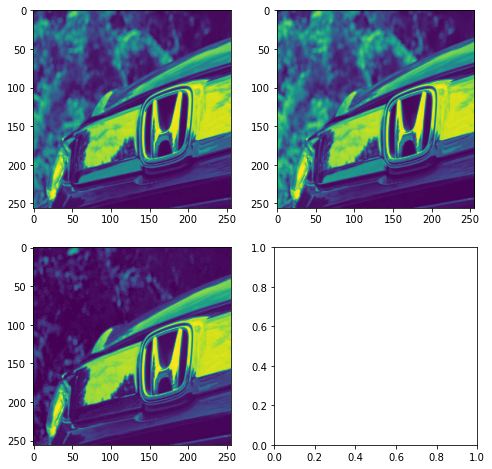

In [15]:
img, label = img_train_low[20]
Show_imgs(img, str(label))
img, label = img_train_high[505]
Show_imgs(img, str(label))

******************1**************************


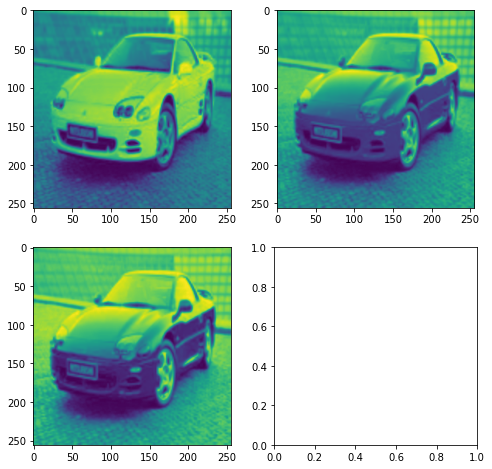

******************0**************************


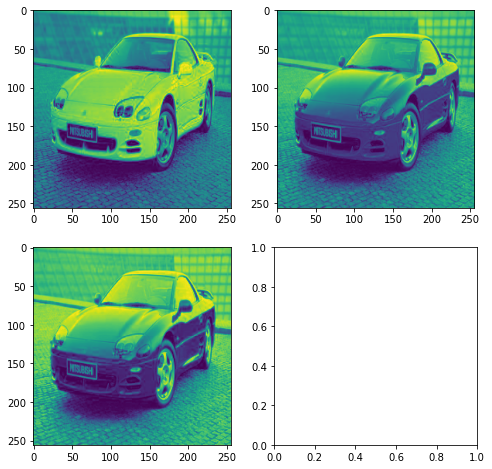

In [16]:
img, label = img_val_low[50]
Show_imgs(img, str(label))
img, label = img_val_high[50]
Show_imgs(img, str(label))

******************1**************************


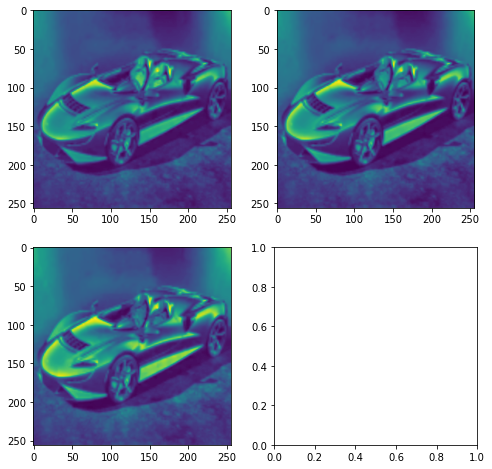

******************0**************************


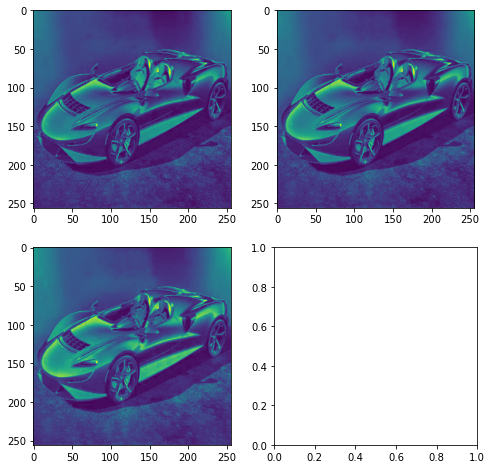

In [17]:
img, label = img_test_low[50]
Show_imgs(img, str(label))
img, label = img_test_high[50]
Show_imgs(img, str(label))

******************0**************************


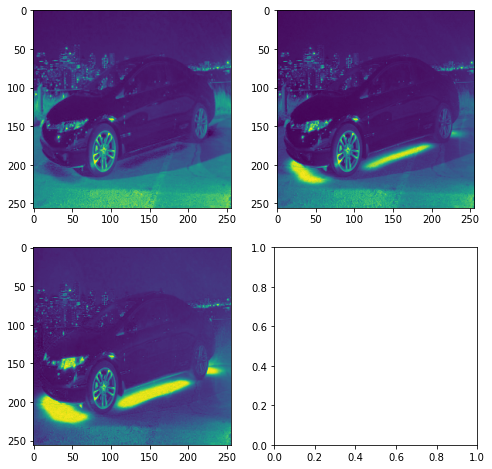

******************0**************************


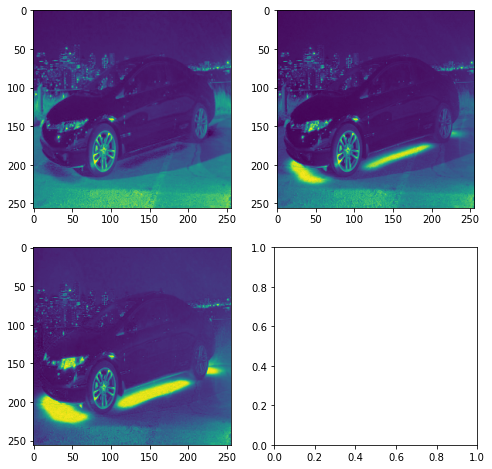

In [18]:
img, label = test_set[0]
Show_imgs(img, str(label))
img, label = test_set[0]
Show_imgs(img, str(label))

## Definición de modelo

In [19]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.funcion = nn.ReLU()
    self.max = nn.MaxPool2d(kernel_size=2, stride=2)
    #256x256
    self.conv11 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, stride = 1,padding=0)
    self.conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride = 1,padding=1)
    #128x128
    self.conv21 = nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=2, stride = 1,padding=0)
    self.conv22 = nn.Conv2d(in_channels=64*2, out_channels=64*2, kernel_size=2, stride = 1,padding=1)
    #64x64
    self.conv31 = nn.Conv2d(in_channels=64*2, out_channels=64*4, kernel_size=2, stride = 1,padding=0)
    self.conv32 = nn.Conv2d(in_channels=64*4, out_channels=64*4, kernel_size=2, stride = 1,padding=1)
    #32x32    
    self.conv41 = nn.Conv2d(in_channels=64*4, out_channels=64*8, kernel_size=2, stride = 1,padding=0)
    self.conv42 = nn.Conv2d(in_channels=64*8, out_channels=64*8, kernel_size=2, stride = 1,padding=1)
    #16x16
    self.conv51 = nn.Conv2d(in_channels=64*8, out_channels=64*16, kernel_size=3, stride = 1,padding=1)
   

  def forward(self, image):
    capas = []
    c1 = self.conv11(image)
    c1 = self.funcion(c1)
    c1 = self.conv12(c1)
    c1 = self.funcion(c1)
    p1 = self.max(c1)
    
    c2 = self.conv21(p1)
    c2 = self.funcion(c2)
    c2 = self.conv22(c2)
    c2 = self.funcion(c2)
    p2 = self.max(c2)

    c3 = self.conv31(p2)
    c3 = self.funcion(c3)
    c3 = self.conv32(c3)
    c3 = self.funcion(c3)
    p3 = self.max(c3)

    c4 = self.conv41(p3)
    c4 = self.funcion(c4)
    c4 = self.conv42(c4)
    c4 = self.funcion(c4)

    p4 = self.max(c4)

    capas.append(c4)
    capas.append(c3)
    capas.append(c2)
    capas.append(c1)
    c5 = self.conv51(p4)
    c5 = self.funcion(c5)

    z=c5
    return z, capas

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.conv11 = nn.Conv2d(in_channels=16*64, out_channels=64*16, kernel_size=3, stride = 1,padding=1)
    self.convTran1 = nn.ConvTranspose2d(in_channels=16*64,out_channels=64*8, kernel_size=2, stride=2, padding=0)
    self.conv21 = nn.Conv2d(in_channels=16*64, out_channels=64*8, kernel_size=2, stride = 1,padding=0)
    self.conv22 = nn.Conv2d(in_channels=8*64, out_channels=64*8, kernel_size=2, stride = 1,padding=1)
    self.convTran2 = nn.ConvTranspose2d(in_channels=8*64,out_channels=64*4, kernel_size=2, stride=2, padding=0)
    self.conv31 = nn.Conv2d(in_channels=8*64, out_channels=64*4, kernel_size=2, stride = 1,padding=0)
    self.conv32 = nn.Conv2d(in_channels=4*64, out_channels=64*4, kernel_size=2, stride = 1,padding=1)
    self.convTran3 = nn.ConvTranspose2d(in_channels=4*64,out_channels=64*2, kernel_size=2, stride=2, padding=0)
    self.conv41 = nn.Conv2d(in_channels=4*64, out_channels=64*2, kernel_size=2, stride = 1,padding=0)
    self.conv42 = nn.Conv2d(in_channels=2*64, out_channels=64*2, kernel_size=2, stride = 1,padding=1)
    self.convTran4 = nn.ConvTranspose2d(in_channels=2*64,out_channels=64, kernel_size=2, stride=2, padding=0)
    self.conv51 = nn.Conv2d(in_channels=2*64, out_channels=64, kernel_size=2, stride = 1,padding=0)
    self.conv52 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=2, stride = 1,padding=1)
    
   
  def forward(self, latent, capas):

    out = latent
    out = F.tanh(self.conv11(latent))
    out = self.convTran1(out)

    out = torch.cat((out,capas[0]), dim=1)
   
    out = F.tanh(self.conv21(out))
    
    out = F.tanh(self.conv22(out))
    
    out = F.tanh(self.convTran2(out))
    out = torch.cat((out,capas[1]), dim=1)
    out = F.tanh(self.conv31(out))
    out = F.tanh(self.conv32(out))
    
    out = F.tanh(self.convTran3(out))
    out = torch.cat((out,capas[2]), dim=1)
    out = F.tanh(self.conv41(out))
    out = F.tanh(self.conv42(out))
    
    out = F.tanh(self.convTran4(out))
    out = torch.cat((out,capas[3]), dim=1)
    out = F.tanh(self.conv51(out))
    out = F.tanh(self.conv52(out))
    
    return out


In [20]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent, capas = self.encoder(x)
        x_recon = self.decoder(latent, capas)
        return  x_recon

In [21]:
def validation(model, valid_loader_lowres, valid_loader_highres, loss_fn):
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for item1, item2 in zip(valid_loader_lowres, cycle(valid_loader_highres)):
            image_batch, _ = item1
            image_compare, _ = item2
            image_batch = image_batch.to(device)
            image_compare = image_compare.to(device)
            image_batch_recon = model(image_batch)
            loss = loss_fn(image_batch_recon, image_compare)
            loss_total += loss.item()

    return loss_total / len(valid_loader_highres)

## Aprendizaje de modelo

In [22]:
from itertools import cycle

def train(model, Epochs, loss_fn, train_loader_lowres, train_loader_highres,valid_loader_lowres, valid_loader_highres):
    train_loss_avg = []
    valid_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
    
      for item1, item2 in zip(train_loader_lowres, cycle(train_loader_highres)):
          image_batch, _ = item1
          image_compare, _ = item2

          image_batch = image_batch.to(device)
          image_compare = image_compare.to(device)
          
          image_batch_recon = model(image_batch)
          loss = loss_fn(image_batch_recon, image_compare)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
      current_loss = validation(model, valid_loader_lowres, valid_loader_highres, loss_fn)
      valid_loss_avg.append(current_loss)
    return train_loss_avg, valid_loss_avg

In [23]:
torch.cuda.ipc_collect()
torch.cuda.is_available()
capacity = 64
latent_dims = 10    
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()


loss_result = train(autoencoder,5,loss,train_loader_lowres,train_loader_highres, test_loader_lowres, test_loader_highres)

C:\Users\flore\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1 / 5] average reconstruction error: 0.020796
Epoch [2 / 5] average reconstruction error: 0.002712
Epoch [3 / 5] average reconstruction error: 0.002042
Epoch [4 / 5] average reconstruction error: 0.001700
Epoch [5 / 5] average reconstruction error: 0.001583


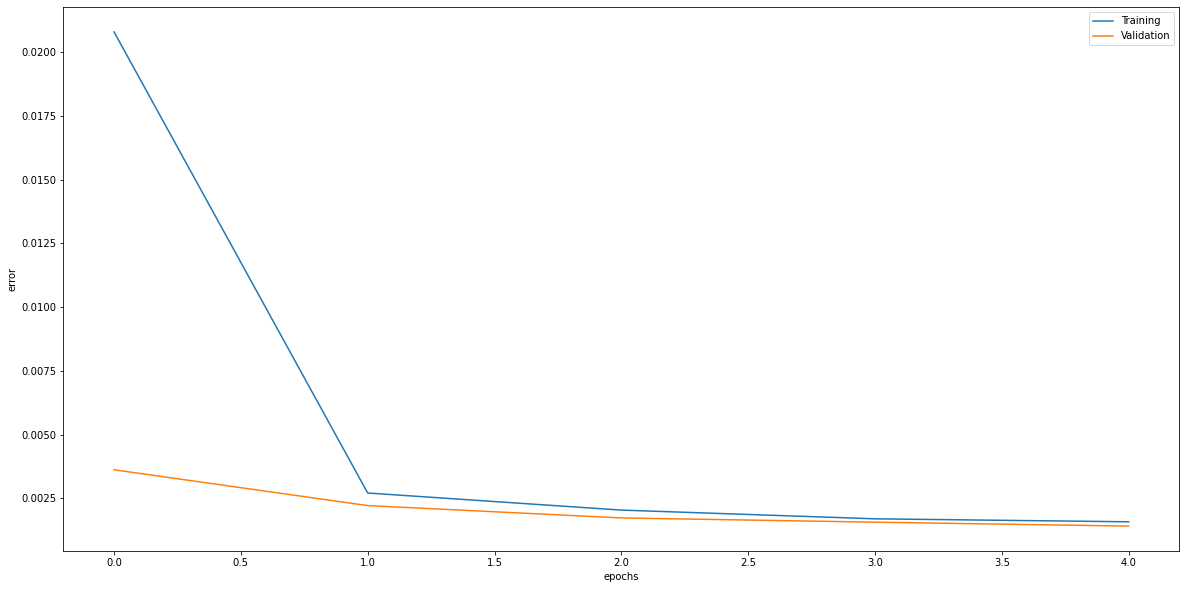

In [24]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.plot(loss_result[0])
plt.plot(loss_result[1])
plt.xlabel("epochs")
plt.ylabel("error")
plt.legend(["Training", "Validation"], loc ="upper right")
plt.show()

## Visualización de imágenes low res, reconstruidas y high res

In [25]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out,10,5)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out, title):
  grilla = torchvision.utils.make_grid(out)
  plt.title(title)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()
  

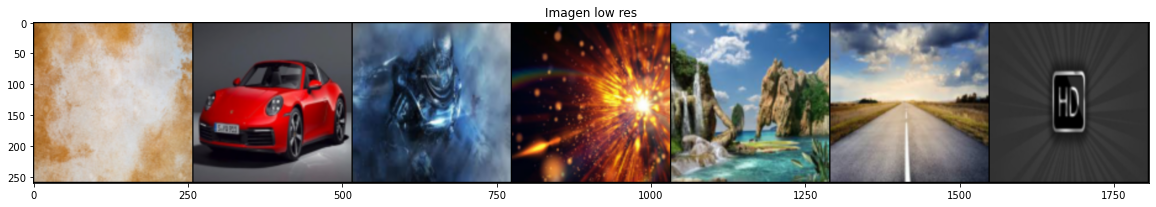

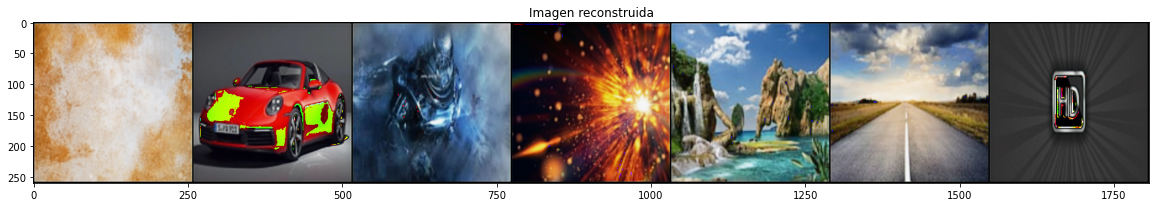

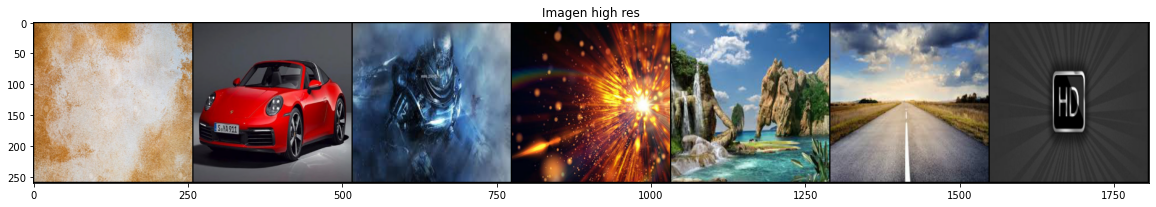

In [26]:
autoencoder.eval()
tensor = torch.zeros(len(test_loader),10)


with torch.no_grad():

  #image,label = iter(test_loader).next()
  #image,label = iter(test_loader).next()
  image,label = iter(test_loader_lowres).next()
  image1,label1 = iter(test_loader_highres).next()
  image = image.to(device)
  z,capas = autoencoder.encoder(image)
  z = z.to('cpu')
  #capas = capas.to('cpu')
  #mean = z.mean(dim=0)

  #std = (z - mean).pow(2).mean(dim=0).sqrt()
  
  #z1 = torch.randn(1000, latent_dims)*std + mean
  #z1 = z1.to(device)
  z1=z.to(device)
  decodificado = autoencoder.decoder(z1, capas)
 
  decodificado = decodificado.to('cpu')

  
  fig1, ax1 = plt.subplots(figsize=(20, 20)) 
  Show_Weight(image[0:7], "Imagen low res")
 
  fig2, ax2 = plt.subplots(figsize=(20, 20))  
  Show_Weight(decodificado[0:7], "Imagen reconstruida")

  fig3, ax3 = plt.subplots(figsize=(20, 20))
  Show_Weight(image1[0:7], "Imagen high res")  
  #Show_Weight(img4[34:50])
  plt.show()

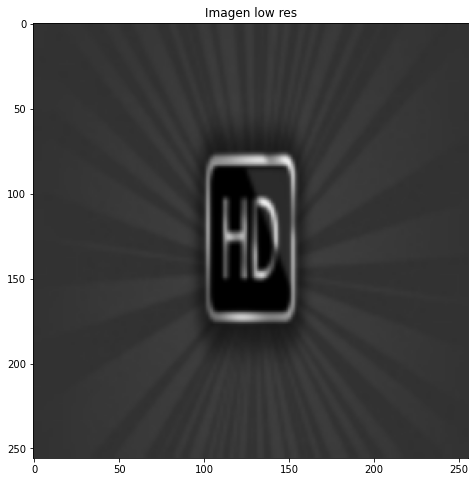

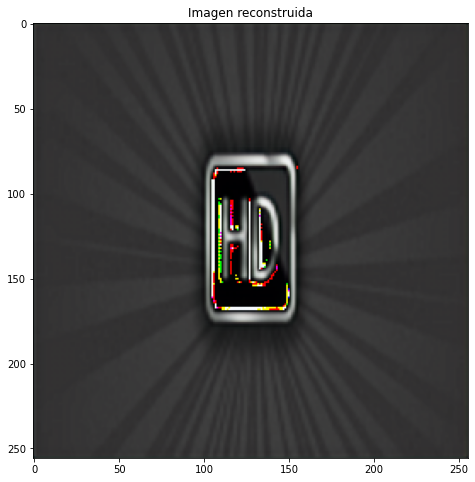

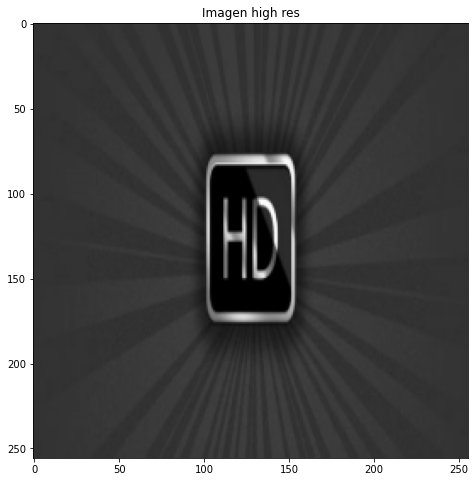

In [27]:
  image,label = iter(test_loader_lowres).next()
  image1,label1 = iter(test_loader_highres).next()
  image = image.to(device)
  z,capas = autoencoder.encoder(image)
  z = z.to('cpu')
  #capas = capas.to('cpu')
  #mean = z.mean(dim=0)

  #std = (z - mean).pow(2).mean(dim=0).sqrt()
  
  #z1 = torch.randn(1000, latent_dims)*std + mean
  #z1 = z1.to(device)
  z1=z.to(device)
  decodificado = autoencoder.decoder(z1, capas)
 
  decodificado = decodificado.to('cpu')

  fig, ax = plt.subplots(figsize=(8, 8))
  Show_Weight(image[6:7], "Imagen low res")
  fig, ax = plt.subplots(figsize=(8, 8))
  Show_Weight(decodificado[6:7], "Imagen reconstruida")
  fig, ax = plt.subplots(figsize=(8, 8))
  Show_Weight(image1[6:7], "Imagen high res")
  #Show_Weight(img4[34:50])
  plt.show()

In [28]:
#   torch.cuda.ipc_collect()
#   torch.cuda.is_available()
#   image,label = iter(test_loader_lowres).next()
#   image1,label1 = iter(test_loader_highres).next()
#   image = image.to(device)
#   z,capas = autoencoder.encoder(image)
#   for i in capas:
#         i.to('cpu')
#   z = z.to('cpu')
#   #capas = capas.to('cpu')
#   mean = z.mean(dim=0)

#   std = (z - mean).pow(2).mean(dim=0).sqrt()
  
#   z1 = torch.randn(16,16)*std + mean
#   z1 = z1.to(device)
#   z1=z.to(device)

#   decodificado = autoencoder.decoder(z1, capas)
 
#   decodificado = decodificado.to('cpu')

#   fig, ax = plt.subplots(figsize=(8, 8))
#   Show_Weight(decodificado[0:4])
#   fig, ax = plt.subplots(figsize=(8, 8))
#   Show_Weight(decodificado[0:4])
#   fig, ax = plt.subplots(figsize=(8, 8))
#   Show_Weight(decodificado[0:4])
#   #Show_Weight(img4[34:50])
#   plt.show()